# ADS 509 Module 3: Group Comparison

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following:

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set.
* Calculate descriptive statistics on the two sets of lyrics and compare the results.
* For each of the four corpora, find the words that are unique to that corpus.
* Build word clouds for all four corpora.

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization).


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.3 MB/s eta 0:00:00


In [3]:
import os
import re
import emoji
import numpy as np
import pandas as pd
import nltk
nltk.download("stopwords")

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Use this space for any additional import statements you need

In [5]:
# Place any addtional functions or constants you need here.

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA :
    for em in emoji.EMOJI_DATA[country] :
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of
    """

    # Place your Module 2 solution here

    if verbose:
        print(f"There are {len(tokens)} tokens in the data.")
        print(f"There are {len(set(tokens))} unique tokens in the data.")
        print(f"There are {len(''.join(tokens))} characters in the data.")
        print(f"The lexical diversity is {len(set(tokens)) / len(tokens):.3f} in the data.")

        counts = Counter(tokens)
        if num_tokens > 0:
                print(counts.most_common(num_tokens))

    return [
          len(tokens),
          len(set(tokens)),
          len("".join(tokens)),
          len(set(tokens)) / len(tokens)
    ]

def contains_emoji(s):

    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return(len(emojis) > 0)

def remove_punctuation(text, punct_set=tw_punct) :
    return("".join([ch for ch in text if ch not in punct_set]))

sw = set([remove_punctuation(w) for w in sw])

def remove_stop(tokens) :
    return([t for t in tokens if t.lower() not in sw])

def tokenize(text) :
    """ Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """

    return([t for t in whitespace_pattern.split(text) if t])

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [16]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/content/drive/MyDrive/M1 Results/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt','robyn':'robynkonichiwa_followers_data.txt'}


In [17]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [18]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])

del(twitter_data_2)

In [19]:
# read in the lyrics here

# Initialize empty lists to store data
artists = []
songs = []
lyrics = []

# Traverse through subfolders in 'lyrics' and collect file names
for item in os.listdir(data_location + lyrics_folder):
    if os.path.isdir(data_location + lyrics_folder + item):
        folder_path = os.path.join(data_location, lyrics_folder, item)

        for lyric_page in os.listdir(folder_path):
            if lyric_page.endswith(".txt"):
                try:
                    artist, song = lyric_page.replace(".txt", "").split("_", 1)
                except ValueError:
                    # Skip files that do not match the pattern
                    continue

                song = song.replace(".txt", "")
                artists.append(artist)
                songs.append(song)

                with open(os.path.join(folder_path, lyric_page), encoding='utf-8') as infile:
                    # Skip first 4 lines: title and blank lines
                    for _ in range(4):
                        next(infile, None)
                    lyrics.append(infile.read())

In [20]:
# Create dataframe
lyrics_data = pd.DataFrame()
lyrics_data['artist'] = artists
lyrics_data['song'] = songs
lyrics_data['lyrics'] = lyrics

lyrics_data.head()

,artist,song,lyrics
0,robyn,givingyouback,In another time\nAnother life\nIn another situ...
1,robyn,beach2k20,(So you wanna go out?\nHow you gonna get there...
2,robyn,includemeout,"It is really very simple\nJust a single pulse,..."
3,robyn,timemachine,"Hey, what did I do?\nCan't believe the fit I j..."
4,robyn,lovekills,If you're looking for love\nGet a heart made o...


In [23]:
# Next is for Twitter, initialize empty lists to store data
all_twitter_data = []

# Loop Through Each File and Combine the Data
for artist, filename in artist_files.items():
    file_path = data_location + twitter_folder + filename

    df = pd.read_csv(file_path, sep="\t", quoting=3, encoding='utf-8')
    df['artist'] = artist  # tag each row with the artist name

    all_twitter_data.append(df)

# Combine all data into one DataFrame
twitter_data = pd.concat(all_twitter_data, ignore_index=True)
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning.

**Lyrics**

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions**

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those.

In [24]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)


In [25]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [26]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
4209343,robyn,~ XII - XII - MCMXCIII ~♐ 7/21/2019 💏 💚💛💜💙 #al...,"[xii, xii, mcmxciii, ♐, 7212019, 💏, 💚💛💜💙, #all..."
1309488,cher,Be who you want to be not what the world wants...,"[want, world, wants, 🌎]"
3333192,cher,Soy precisamente todo lo que creas que no soy....,"[soy, precisamente, todo, lo, que, creas, que,..."
1039794,cher,they/she 💖💜💙,"[theyshe, 💖💜💙]"
4146063,robyn,"◉▾◉ Writer, music-maker, idealist, seeker of l...","[◉▾◉, writer, musicmaker, idealist, seeker, li..."
3180856,cher,I love music :) I play the clarinet in band an...,"[love, music, play, clarinet, band, taken, bes..."
108588,cher,Marty • Twitch broadcaster • Part-time sith • ...,"[marty, •, twitch, broadcaster, •, parttime, s..."
2874035,cher,"teacher, love family, friends, music, cooking ...","[teacher, love, family, friends, music, cookin..."
2016158,cher,*she/her* Native Kansan🌻Horticulturist🌳Dog mom🐾,"[sheher, native, kansan🌻horticulturist🌳dog, mom🐾]"
2371732,cher,looking forward to achieve great things in lif...,"[looking, forward, achieve, great, things, lif..."


With the data processed, we can now start work on the assignment questions.

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One potential improvement to my tokenization would be to handle contractions more effectively—for example, splitting "can't" into "can" and "not", or mapping "I'm" to "I am". This would help align tokens with standard word forms and improve downstream tasks like sentiment analysis or frequency counts.

## Calculate descriptive statistics on the two sets of lyrics and compare the results.


In [30]:
# your code here
# For Cher
# Flatten tokens into a single list
cher_lyrics = lyrics_data[lyrics_data.artist=="cher"]['tokens'].sum()

# Calculate descriptive statistics
descriptive_stats(cher_lyrics, num_tokens=10)

There are 32660 tokens in the data.
There are 3648 unique tokens in the data.
There are 159604 characters in the data.
The lexical diversity is 0.112 in the data.
[('love', 966), ('know', 480), ('baby', 315), ('time', 313), ('see', 308), ('oh', 306), ('one', 275), ('go', 268), ('like', 267), ('come', 263)]


[32660, 3648, 159604, 0.11169626454378445]

In [31]:
# For Robyn
# Flatten tokens into a single list
robyn_lyrics = lyrics_data[lyrics_data.artist == "robyn"]['tokens'].sum()

# Calculate descriptive statistics
descriptive_stats(robyn_lyrics, num_tokens=10)

There are 13929 tokens in the data.
There are 2108 unique tokens in the data.
There are 68812 characters in the data.
The lexical diversity is 0.151 in the data.
[('know', 305), ('love', 269), ('got', 249), ('like', 230), ('baby', 220), ('never', 155), ('dance', 148), ('beat', 144), ('get', 141), ('killing', 136)]


[13929, 2108, 68812, 0.15133893316103095]

Q: what observations do you make about these data?

A:  Cher has more data then Robyn. Robyn has higher lexical diversity. Cher has more senstive words like love, know, like and baby while Robyn has other more physical movement words like dance and beat. Similar words between the two artists are love, know, baby, and like.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis.

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it.

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing.

In this section find 10 tokens for each of your four corpora that meet the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [39]:
# your code here
# Transform lyrics into token lists by artist
cher_tw = twitter_data[twitter_data.artist=="cher"].tokens.to_list()
cher_tw = [item for sublist in cher_tw for item in sublist]
robyn_tw = twitter_data[twitter_data.artist=="robyn"].tokens.to_list()
robyn_tw = [item for sublist in robyn_tw for item in sublist]

# Count the token frequencies in lyrics and Twitter
cher_lyrics_count = Counter(cher_lyrics)
cher_tw_count = Counter(cher_tw)
robyn_lyrics_count = Counter(robyn_lyrics)
robyn_tw_count = Counter(robyn_tw)

# Identify which tokens that appear at least 5 times in Cher's Lyrics
selected_tokens = {w for w,c in cher_lyrics_count.items() if c >= 5}

# Identify tokens that appear at least 5 times in the four datasets
for ct in [cher_tw_count, robyn_lyrics_count, robyn_tw_count] :
    selected_tokens = selected_tokens.intersection({w for w,c in ct.items() if c >= 5})


In [41]:
# Define the Top Tokens
def get_top_tokens(counter,reference_counters,allowed_tokens,top_n=10) :

  comparison = Counter()
  results = defaultdict(float)

  for ct in reference_counters :
    comparison += ct

  for token, count in counter.items() :
    if token in allowed_tokens :
      results[token] = count/comparison[token]

  results = sorted([(k,v) for k, v in results.items()],key=lambda x: x[1])[-top_n:]

  return(results)

In [44]:
# Looking at top tokens in Cher's lyrics and comparing against Cher's Twitter text and Robyn's Lyrics and Twitter text
get_top_tokens(cher_lyrics_count,[cher_tw_count, robyn_lyrics_count, robyn_tw_count],selected_tokens)

[('gotta', 0.056914893617021275),
 ('deny', 0.05755395683453238),
 ('gonna', 0.0593656817565736),
 ('tears', 0.0910569105691057),
 ('ooo', 0.09836065573770492),
 ('ohh', 0.10084033613445378),
 ('tonight', 0.12215320910973085),
 ('knock', 0.1417004048582996),
 ('chorus', 0.33707865168539325),
 ('ooh', 0.43795620437956206)]

In [45]:
# Looking at top tokens in Cher's Twitter text and comparing against Cher's Lyrics text and Robyn's Lyrics and Twitter text
get_top_tokens(cher_tw_count,[cher_lyrics_count, robyn_lyrics_count, robyn_tw_count], selected_tokens)

[('mama', 17.87962962962963),
 ('two', 17.952324195470798),
 ('boys', 18.303797468354432),
 ('stand', 19.641975308641975),
 ('truth', 20.893063583815028),
 ('woman', 22.005272407732864),
 ('friend', 22.27148703956344),
 ('faith', 22.67132867132867),
 ('proud', 25.343698854337152),
 ('god', 26.842227378190255)]

In [46]:
# Looking at top tokens in Robyn's lyrics and comparing against Robyn's Twitter text and Cher's Lyrics and Twitter text
get_top_tokens(robyn_lyrics_count,[cher_lyrics_count,cher_tw_count, robyn_tw_count], selected_tokens)

[('shake', 0.0400890868596882),
 ('crash', 0.045714285714285714),
 ('alright', 0.046153846153846156),
 ('deny', 0.06521739130434782),
 ('ooh', 0.07065217391304347),
 ('88', 0.07344632768361582),
 ('beat', 0.07960199004975124),
 ('ohh', 0.09166666666666666),
 ('ooo', 0.09836065573770492),
 ('chorus', 0.3149171270718232)]

In [47]:
# Looking at top tokens in Robyn's Twitter text and comparing against Robyn's Lyrics text and Cher's Lyrics and Twitter text
get_top_tokens(robyn_tw_count,[cher_lyrics_count,cher_tw_count,robyn_lyrics_count], selected_tokens)

[('crash', 0.1509433962264151),
 ('dance', 0.15288565529446466),
 ('head', 0.1562164098889287),
 ('88', 0.15853658536585366),
 ('music', 0.1711869484065719),
 ('spinning', 0.21621621621621623),
 ('men', 0.23844405152816367),
 ('sound', 0.2536231884057971),
 ('til', 0.39913700107874867),
 ('till', 0.6528758829465187)]

Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A: The top tokens show that Cher and Robyn use different kinds of language in their lyrics and on Twitter. Cher’s lyrics focus more on emotional and rhythmic words like “love,” “gonna,” and “ohh,” while her Twitter posts highlight personal beliefs and identity with words like “truth,” “faith,” and “god.” Robyn, on the other hand, uses similar language in both her lyrics and tweets, often using music and dance-related words like “shake,” “crash,” and “dance.” This suggests Cher shows different sides of herself in her songs and online, while Robyn keeps a more consistent voice across both.

## Build word clouds for all four corpora.

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book.


In [48]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

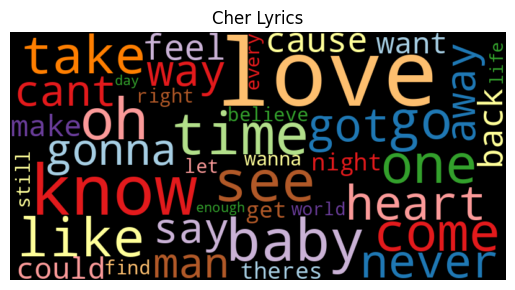

In [52]:
# Lyrics Word Cloud
cher_lyrics_count = count_words(lyrics_data[lyrics_data['artist']=="cher"])
robyn_lyrics_count = count_words(lyrics_data[lyrics_data['artist']=="robyn"])

wordcloud(cher_lyrics_count['freq'], title="Cher Lyrics", max_words=40, stopwords=None)

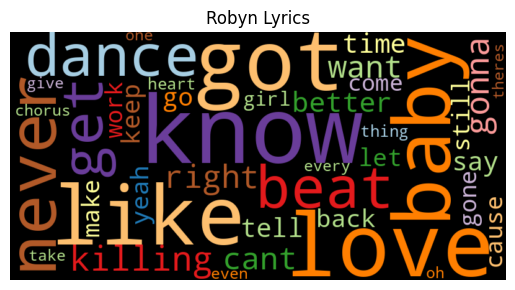

In [53]:
wordcloud(robyn_lyrics_count['freq'], title="Robyn Lyrics", max_words=40, stopwords=None)

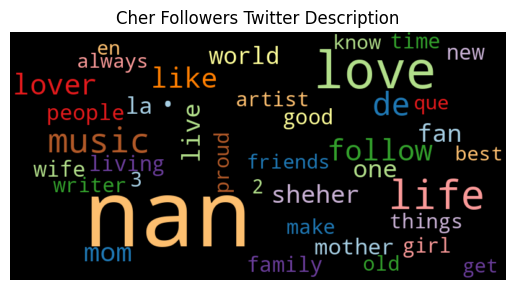

In [54]:
# Twitter Word Cloud
cher_tw_count = count_words(twitter_data[twitter_data['artist']=="cher"])
robyn_tw_count = count_words(twitter_data[twitter_data['artist']=="robyn"])

wordcloud(cher_tw_count['freq'], title="Cher Followers Twitter Description", max_words=40, stopwords=None)

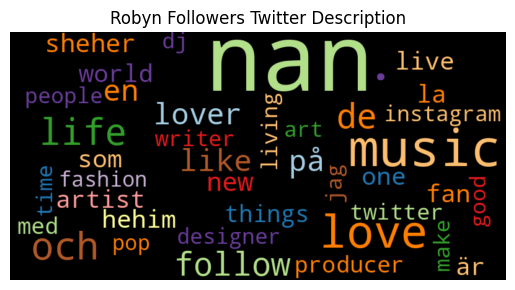

In [55]:
wordcloud(robyn_tw_count['freq'], title="Robyn Followers Twitter Description", max_words=40, stopwords=None)

Q: What observations do you have about these (relatively straightforward) wordclouds?

A: The word clouds show that Cher’s lyrics often focus on love and emotion, with common words like “love,” “baby,” “heart,” and “feel.” Robyn’s lyrics also mention “love” but lean more toward energy and action, using words like “dance,” “beat,” and “killing.” In the Twitter descriptions, Cher’s followers tend to highlight personal values and identity with words like “truth,” “faith,” “god,” and “music.” Robyn’s followers mention more creative and lifestyle-related terms like “producer,” “life,” “music,” “live,” and “follow.” Overall, Cher’s content feels more emotional and personal, while Robyn’s reflects performance, movement, and creativity.